In [70]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from implementations import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the training data into feature matrix, class labels, and event ids:

In [71]:
import datetime
from proj1_helpers import *

DATA_TRAIN_PATH = 'data/train.csv' 
y, X, ids = load_csv_data(DATA_TRAIN_PATH)
X.shape

(250000, 30)

# Data Exploration

In [3]:
#handmade varaible containing the names of the columns of X, it might be usefull for us to compare datasets
feature_names=['DER_mass_MMC','DER_mass_transverse_met_lep','DER_mass_vis','DER_pt_h','DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_deltar_tau_lep','DER_pt_tot','DER_sum_pt','DER_pt_ratio_lep_tau','DER_met_phi_centrality','DER_lep_eta_centrality','PRI_tau_pt','PRI_tau_eta','PRI_tau_phi','PRI_lep_pt','PRI_lep_eta','PRI_lep_phi','PRI_met','PRI_met_phi','PRI_met_sumet','PRI_jet_num','PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi','PRI_jet_subleading_pt','PRI_jet_subleading_eta','PRI_jet_subleading_phi','PRI_jet_all_pt']

## Missing value ratio
let's first have a look a the number of missing values in each feature (columns) of our dataset. Features with a high ratio (#missing values/#values) are unlikely to carry much information 

In [4]:
def missing_values_r(v):
    'compute the missing values ratio for a given vector v'
    return 1-np.sum(v>-999)/len(v)

ratios={} #dictionary linkng a feature name with its missing values ratio
for feature_index in range(len(X[0])):
    ratios[feature_index]=missing_values_r(X[:,feature_index])
ratios   

{0: 0.15245600000000004,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.709828,
 5: 0.709828,
 6: 0.709828,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.709828,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.399652,
 24: 0.399652,
 25: 0.399652,
 26: 0.709828,
 27: 0.709828,
 28: 0.709828,
 29: 0.0}

We imediatly see that the features of indices 4,5,6,26,27,28,12 have a 70 percent rate of missing values. We will probably discard them during the preprocessing process. 

In fact we can already discard them, thes is no use of keeping them during the Data exploration process. To remove the we simply use a threshold t that will be the upper bound on 'acceptable' missing values ration.

Note that t is an hyperparameter of our future model

In [5]:
#threshold
t=0.7
columns_to_delete=[]
for feature_index in ratios:
    if ratios[feature_index]>t:
        columns_to_delete.append(feature_index)
print(columns_to_delete)
X=np.delete(X,obj=columns_to_delete,axis=1)

#we also have to update the columns names since we removed some of them
feature_names=np.delete(feature_names,obj=columns_to_delete,axis=0)

[4, 5, 6, 12, 26, 27, 28]


In [6]:
X.shape

(250000, 23)

## Variance
In this section we study the variance of each feature, low variance features are unlikely to carry much information

In [7]:
stds=[]
for feature_index in range(np.shape(X)[1]):
    feature=min_max_scaler(X[:,feature_index])
    stds.append(np.std(feature))
stds

NameError: name 'min_max_scaler' is not defined

## Correlations
here we study the different correlations because...

In [9]:
def correlation(a,b):
    #since we want to measure linear correlation between features and target we will use the pearson corrlation provided in numpy 
    return np.corrcoef(a,b)[0][1]

#### Correlation Feature/Target
lets first check which features are correlated or not with the target vector 'y'. Uncorrelated features have no use to predict 'y'

In [10]:
correlations=[]

for feature_index in range(len(X[0])):
    #contains one feature of the dataset, namely one column of Tx
    feature=X[:,feature_index]
    
    #first of all we have to filter out all the values equal to -999 (unknown values)
    indices=feature>-999
    feature=feature[indices]
    target=y[indices]
    
    corr = correlation(feature,target)
    
    correlations.append(corr)

#### Mutual correlation between features 
Having a look at the mutual correlation between features is important because if two of them are highly correlated we could just use one and simplify the model

In [11]:
correlation_matrix=[]
for index1 in range(len(X[0])):
    correlations_row=[]#row of the correlation matrix
    for index2 in range(len(X[0])):
        #contains one feature of the dataset, namely one column of Tx
        feature1=X[:,index1]
        feature2=X[:,index2]

        #first of all we have to filter out all the values equal to -999 (unknown values)
        indices=(feature1>-999) * (feature2>-999)
        feature1=feature1[indices]
        feature2=feature2[indices]
        
        corr = correlation(feature1,feature2)
        
        correlations_row.append(corr)
    correlation_matrix.append(correlations_row)

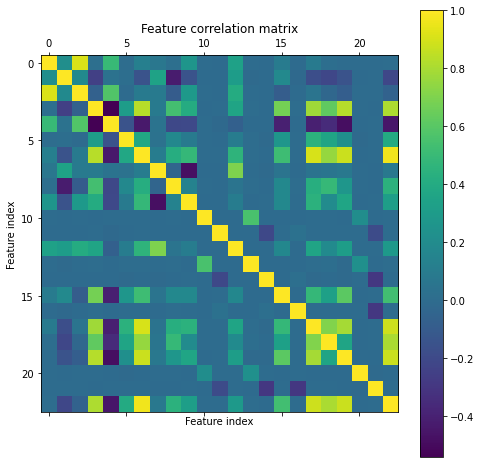

In [12]:
plt.figure(figsize=(8,8))
plt.matshow(correlation_matrix,fignum=1)
plt.colorbar()
plt.title("Feature correlation matrix")
plt.ylabel("Feature index")
plt.xlabel("Feature index")
plt.show()

In [13]:
threshold=0.8
features_to_delete=[]
for feature1_index in range(np.shape(correlation_matrix)[1]):
    for feature2_index in range(np.shape(correlation_matrix)[0]):
            corr=correlation_matrix[feature1_index][feature2_index]
            if np.abs(corr)>threshold and feature1_index>feature2_index:
                features_to_delete.append(feature2_index)

features_to_delete=np.unique(features_to_delete)
features_to_delete

array([ 0,  3,  6, 17, 18, 19])

In [14]:
X=np.delete(X,obj=features_to_delete,axis=1)

#we also have to update the columns names since we removed some of them
feature_names=np.delete(feature_names,obj=features_to_delete,axis=0)

We can see high values of correlation on the diagonal, these come from the auto-correlation of the features. The most interesting information that we see here is the others values that are close to one, these correspond to high correlations between two different features.

Note that the Feature correlation matrix is symetric 

## Correlations
In this section we will study the distributions (feature by feature) of the dataset. The result may help us to decide what to do with the missing values (-999) 

DER_mass_MMC 0


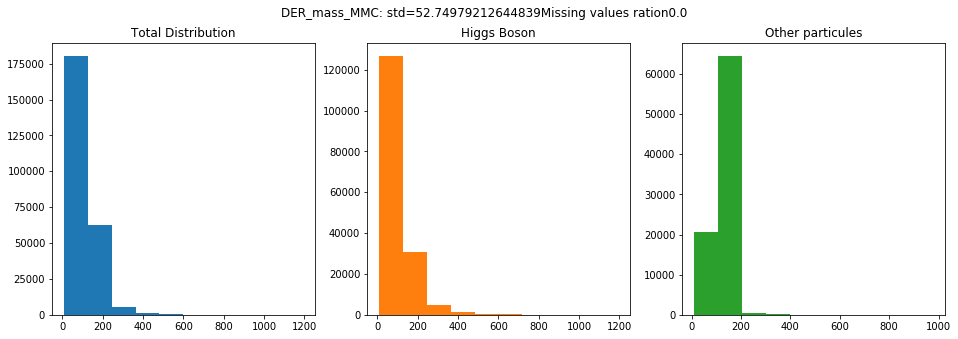

DER_mass_transverse_met_lep 1


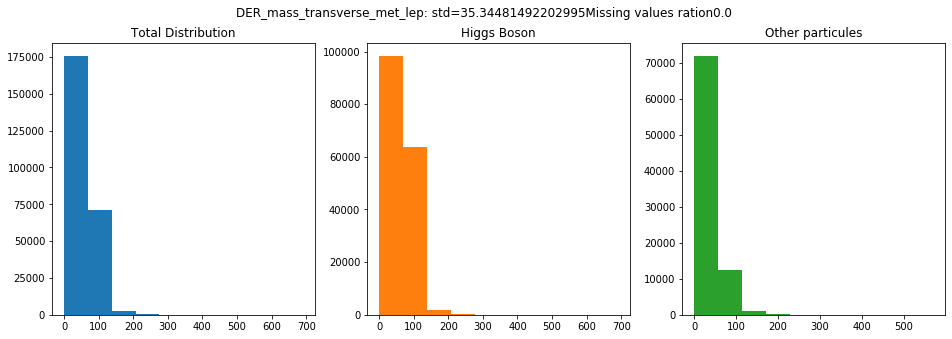

DER_mass_vis 2


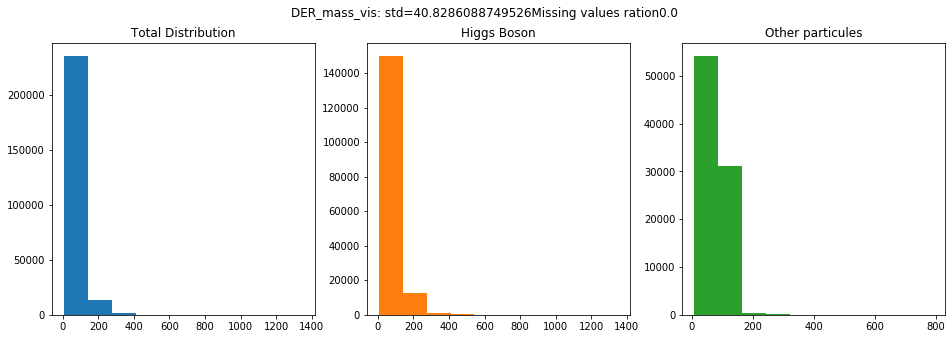

DER_pt_h 3


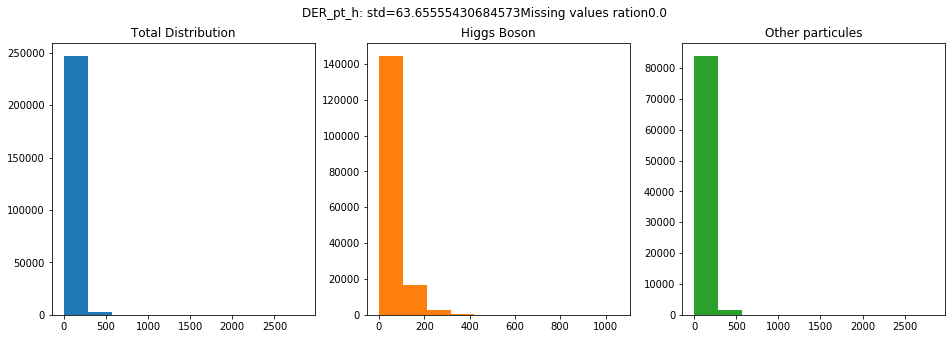

DER_deltar_tau_lep 4


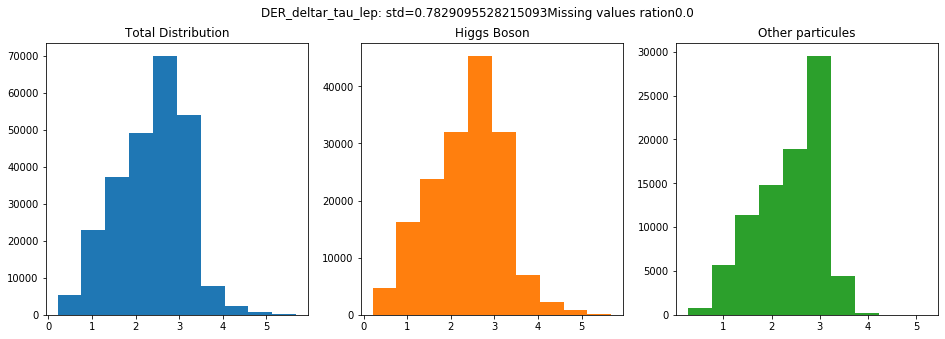

DER_pt_tot 5


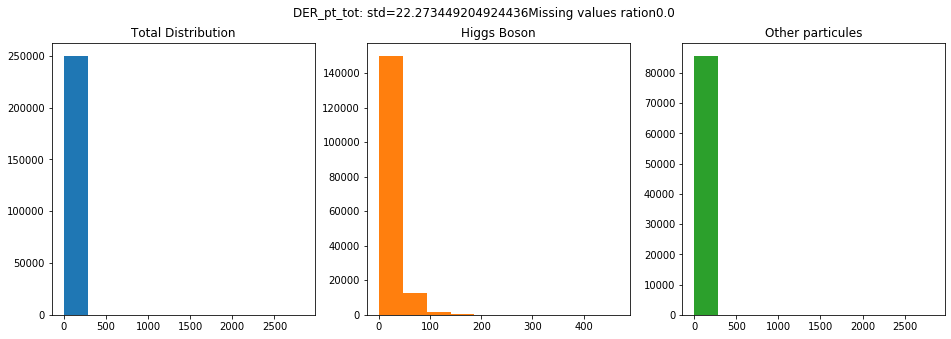

DER_sum_pt 6


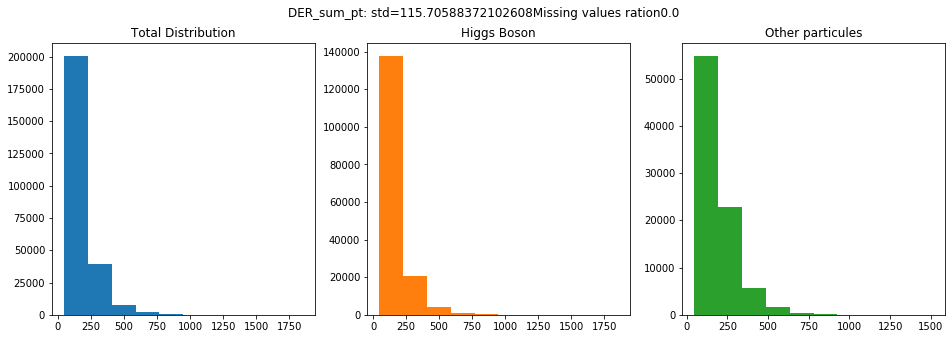

DER_pt_ratio_lep_tau 7


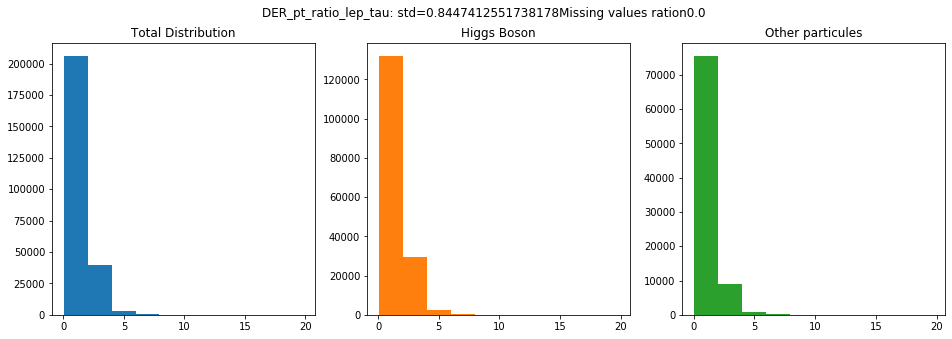

DER_met_phi_centrality 8


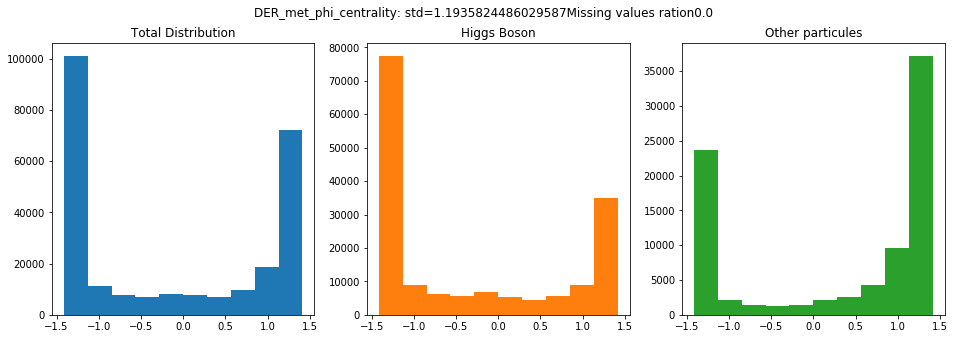

PRI_tau_pt 9


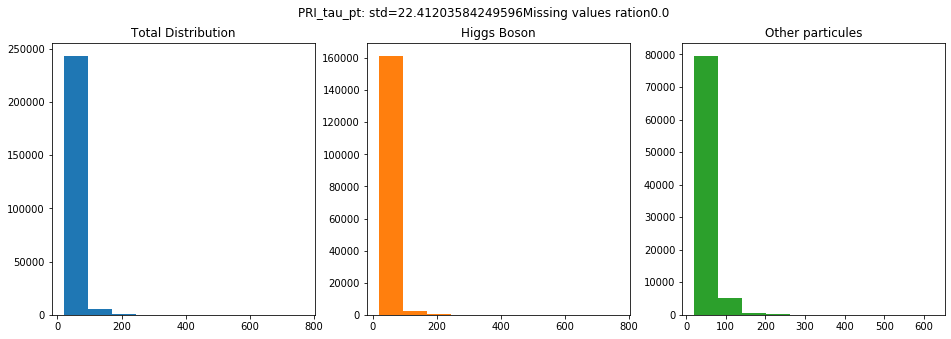

PRI_tau_eta 10


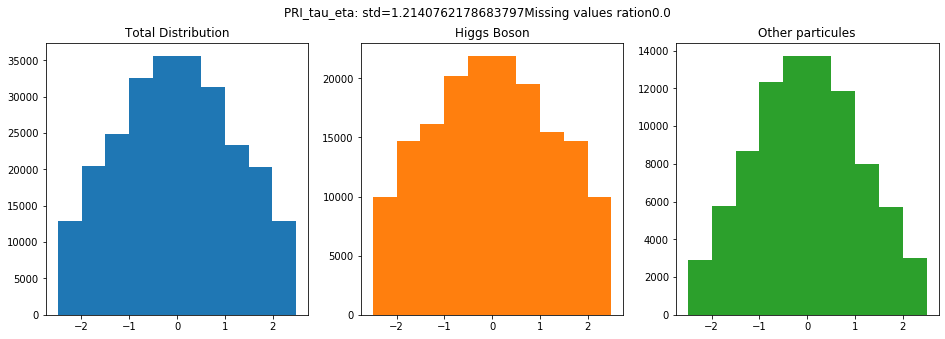

PRI_tau_phi 11


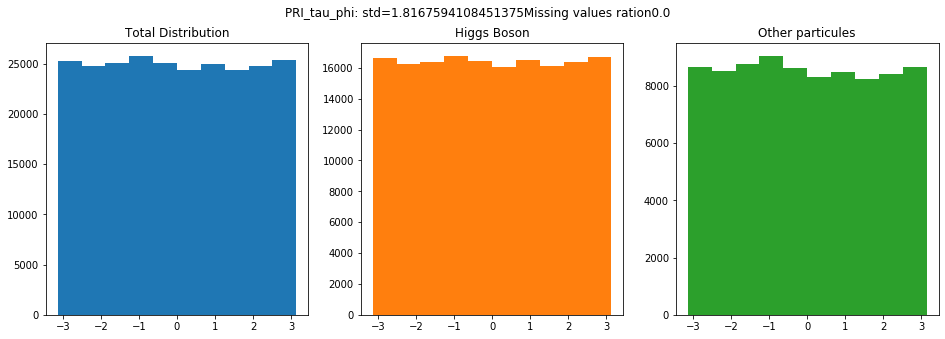

PRI_lep_pt 12


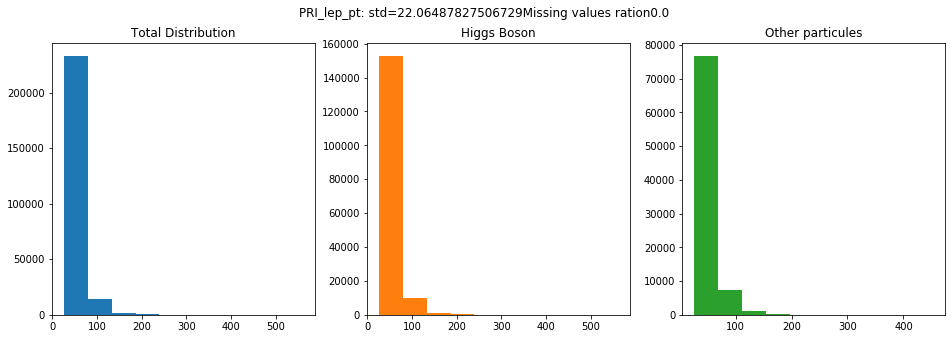

PRI_lep_eta 13


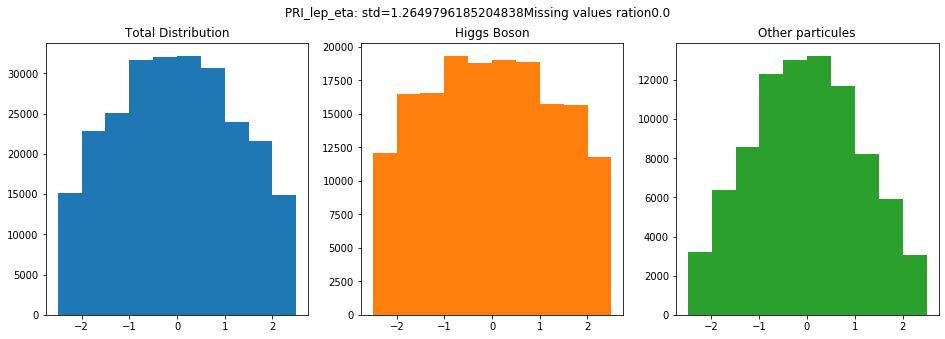

PRI_lep_phi 14


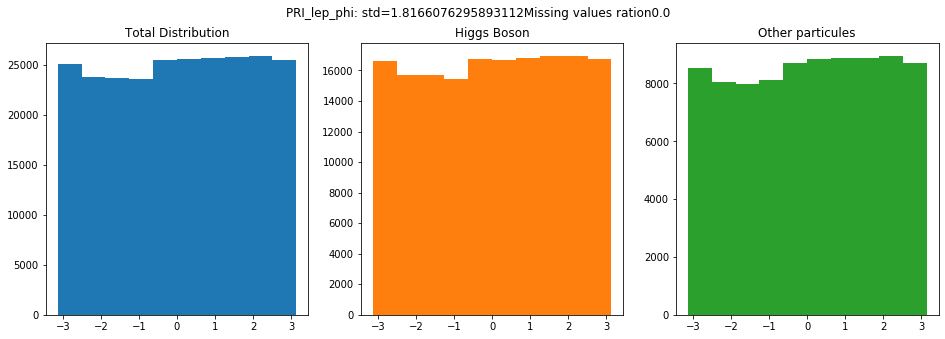

PRI_met 15


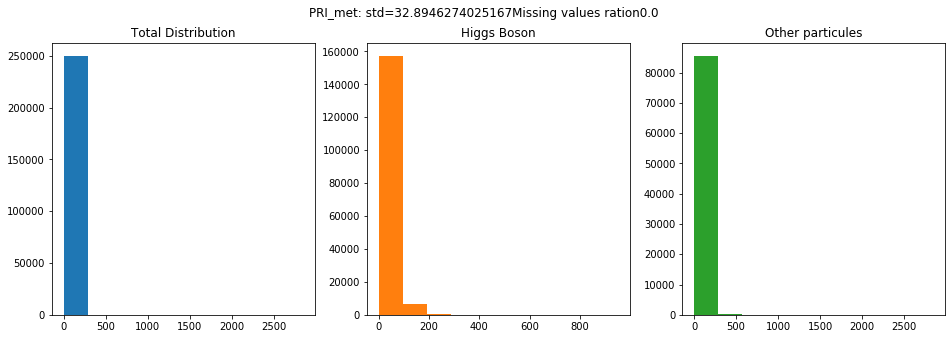

PRI_met_phi 16


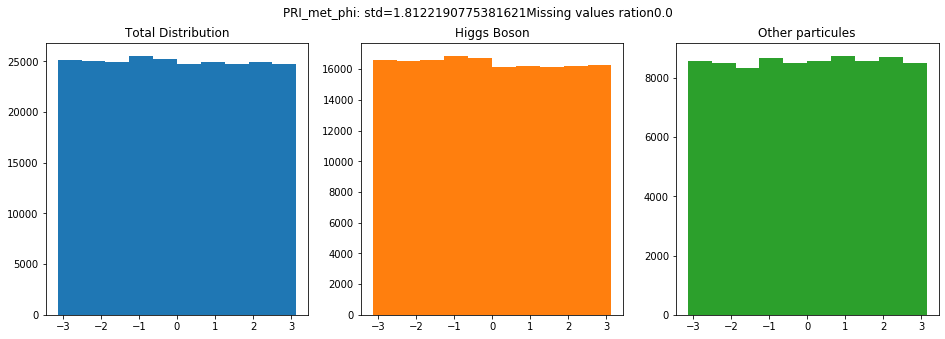

PRI_met_sumet 17


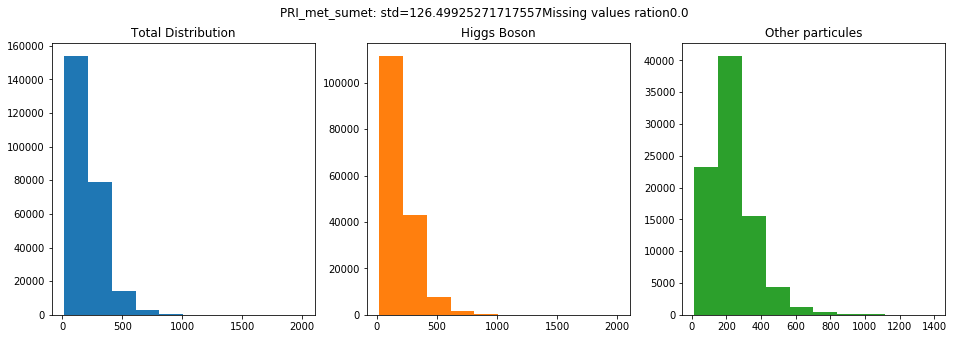

PRI_jet_num 18


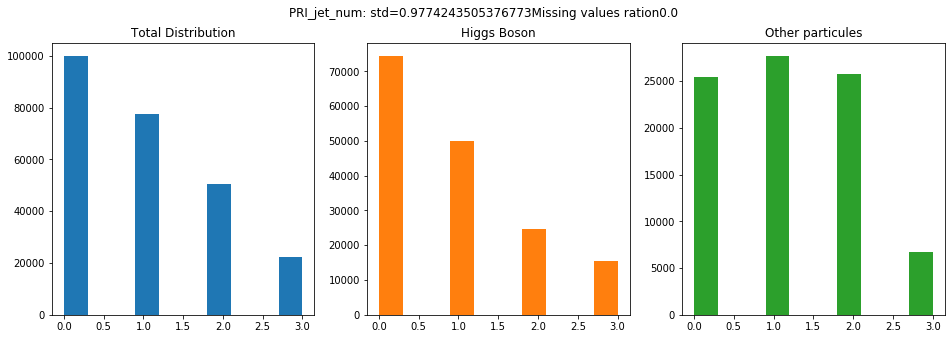

PRI_jet_leading_pt 19


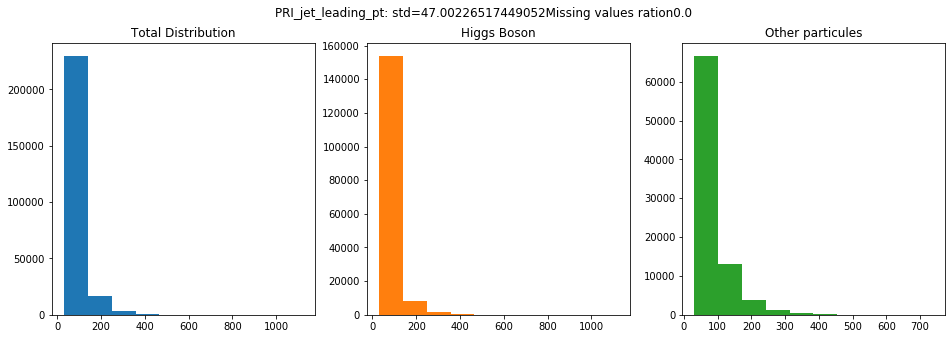

PRI_jet_leading_eta 20


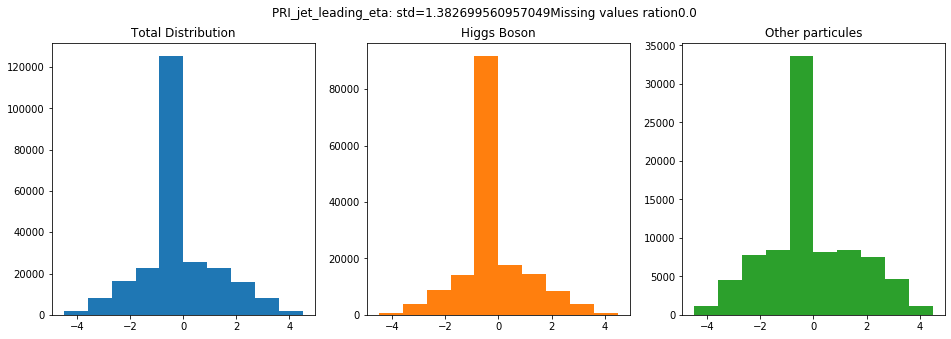

PRI_jet_leading_phi 21


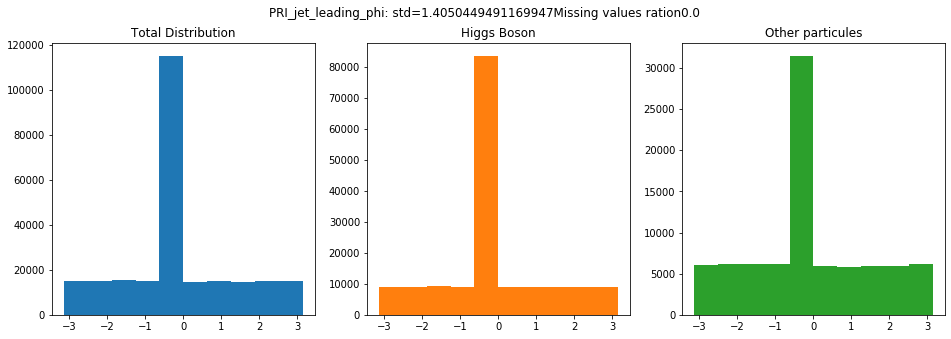

PRI_jet_all_pt 22


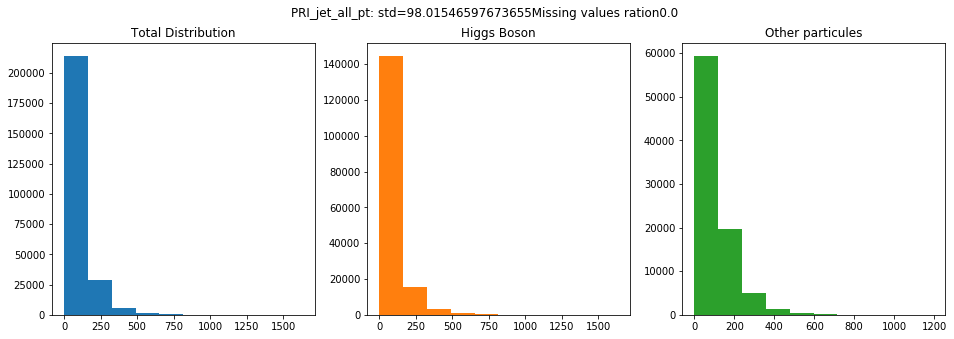

In [10]:
def plotHistogram(index, title,X,labels, filterMissingValues=True):
    extraCond = np.logical_or(np.full(labels.shape, not filterMissingValues, dtype=bool), (X[:,index]>-990))
    fig, axs = plt.subplots(1, 3,figsize=(16,5))
    axs[0].hist(X[extraCond,index])
    axs[0].set_title('Total Distribution')
    axs[1].hist(X[np.logical_and(labels==-1, extraCond),index], color='tab:orange')
    axs[1].set_title('Higgs Boson')
    axs[2].hist(X[np.logical_and(labels==1, extraCond),index], color='tab:green')
    axs[2].set_title('Other particules')
    fig.suptitle(title+ ": std="+ str(np.std(X[extraCond,index]))+"Missing values ration"+ str(missing_values_r(X[:,index])))
    print(title,index)
    #******************
    #plt.hist(X[:,index])
    plt.show()

for index in range(X.shape[1]):
    plotHistogram(index,feature_names[index],X,y)

In [83]:
heavy_tailed_indices=[0,1,2,3,5,6,7,9,12,15,17,19,22]
dummy=[8] #at 0  18 ???

C:\Users\Augustin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


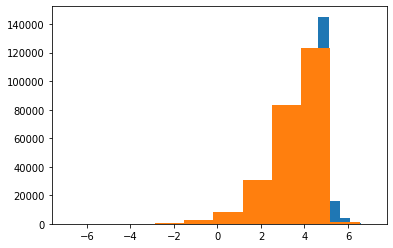

In [30]:
for i in heavy_tailed_indices[:2]:
    feature=X[:,i]


0


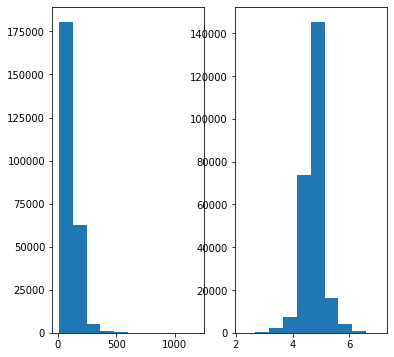

1


C:\Users\Augustin\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


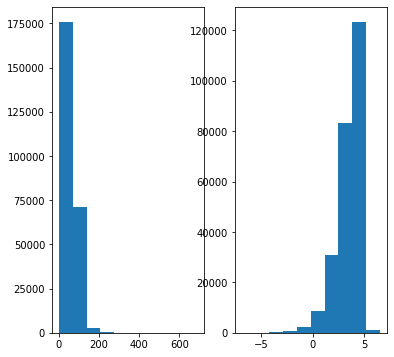

2


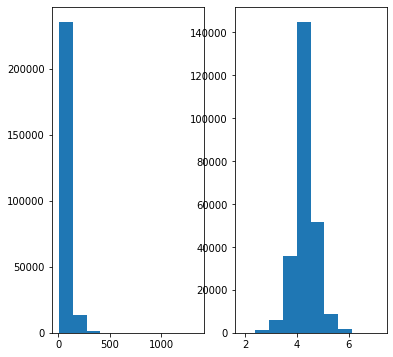

3


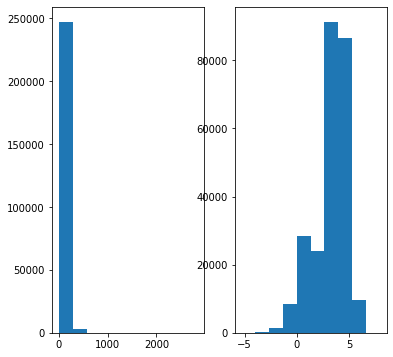

5


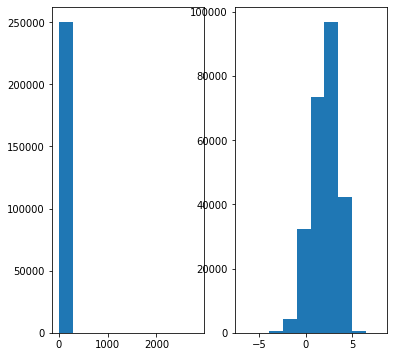

6


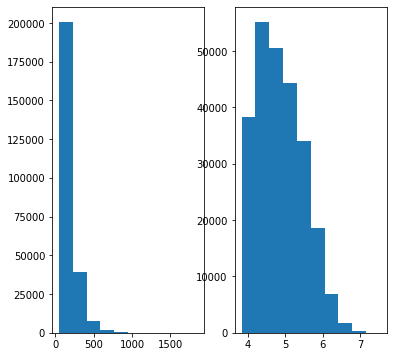

7


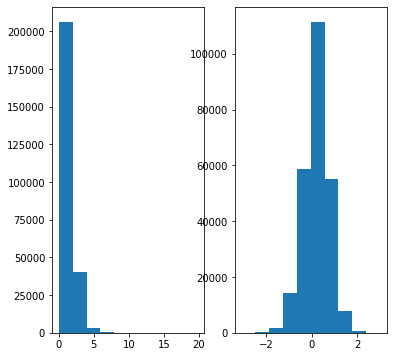

9


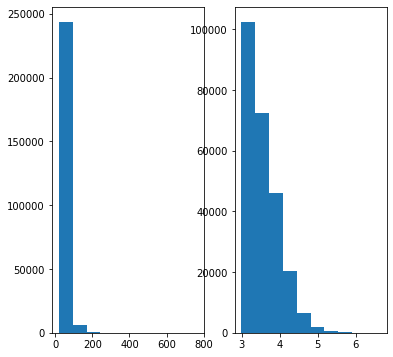

12


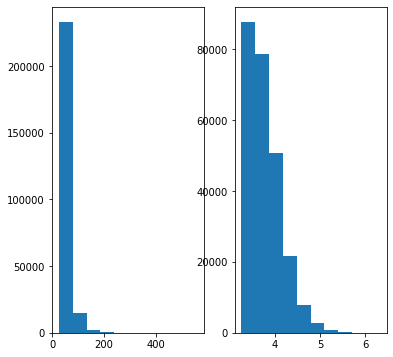

15


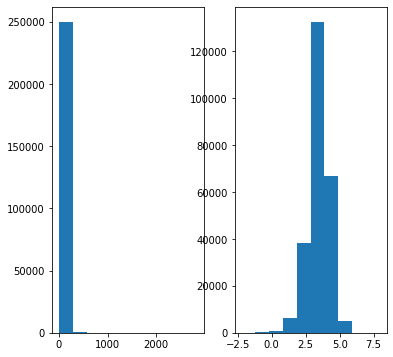

17


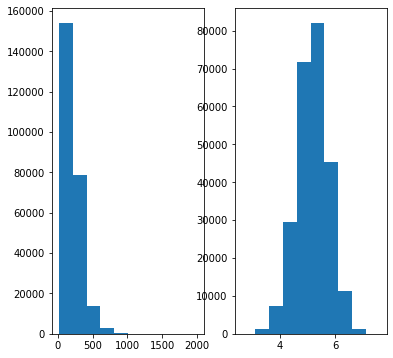

19


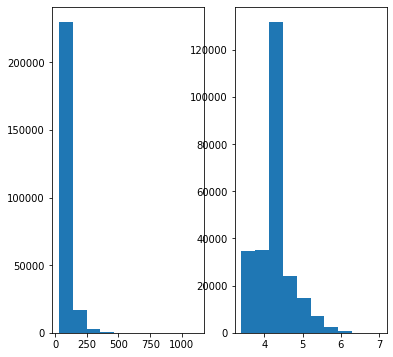

22


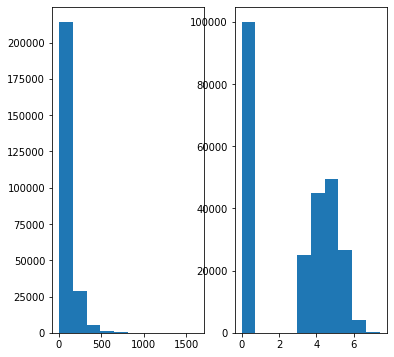

In [38]:
for i in heavy_tailed_indices:
    print(i)
    feature=X[:,i]
    plt.figure(figsize=(6,6))
    plt.subplot(121)
    plt.hist(feature)
    plt.subplot(122)
    l=np.log(X[:,i])
    l[l==-np.inf]=0
    plt.hist(l)
    plt.show()

# Data preprocessing
## Feature reduction : Nans and Correlation

## Train/Test set split

In [51]:
from missing_values import *

interpolator = MeanInterpolator()
X = interpolator.interpolate(X)
print(X.shape)

(250000, 30)


In [109]:
logged=np.array(X, copy=True)
for i in heavy_tailed_indices:
    l=np.log(X[:,i])
    l[l==-np.inf]=0
    l[np.isnan(l)]=0
    logged[:,i]=l


C:\Users\Augustin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Augustin\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
def train_test_split(X,y,train_ratio=0.67,seed=43):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    np.random.seed(seed)                # set seed
    N = X.shape[0]                      # number of data points 
    indices = np.arange(N)              # all row indices
    np.random.shuffle(indices)          # shuffle indices
    split_index=int(N*train_ratio)      # last training point 
    mask_tr = indices[:split_index]     # mask for training set
    mask_te = indices[split_index:]     # mask for testing set

    return X[mask_tr],y[mask_tr],X[mask_te],y[mask_te]

In [110]:
train_set,train_target,test_set,test_target = train_test_split(logged,y,train_ratio=0.67)
print("train and test sets shape before expansion:",train_set.shape,test_set.shape)

train and test sets shape before expansion: (167500, 30) (82500, 30)


## Polynomial feature expansion

In [111]:
from build_polynomial import PolynomialExpansion

### Grid Search for the best $\lambda$ and the best degree

In [112]:
degrees = np.arange(2,10)
lambdas = np.logspace(0, 3, 30)

rmse_tr = []
rmse_te = []

best_lambda, best_degree, min_rmse = 0, 0, np.inf
best_poly_exp = None
best_weights  = None
for degree in degrees:
    expanser = PolynomialExpansion(degree)  # create object for polynomial expansion
    x_tr = expanser.expand(train_set)       # expand the training set
    x_te = expanser.expand(test_set)        # expand the test set
    y_tr = train_target                     # renaming for consistency
    y_te = test_target                      # renaming for consistency
    for ind, lambda_ in enumerate(lambdas):
        weights, mse_tr = ridge_regression(y_tr,x_tr,lambda_)   # ridge regression with a given lambda
        mse_te = loss_least_squares(y_te,x_te,weights)          # compute loss on test set
        
        rmse_tr.append(np.sqrt(2*mse_tr))
        rmse_te.append(np.sqrt(2*mse_te))
        if rmse_te[-1] < min_rmse:  # if a better parameters are found : update 
            best_lambda, best_degree, min_rmse = lambda_, degree, rmse_te[-1]
            best_poly_exp = expanser
            best_weights=weights
        
        # ***************************************************
        print("degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               d=degree, l=lambda_, tr=rmse_tr[-1], te=rmse_te[-1]))
        
rmse_tr = np.asarray(rmse_tr).reshape((len(lambdas), len(degrees)))
rmse_te = np.asarray(rmse_te).reshape((len(lambdas), len(degrees)))


degree=2, lambda=1.000, Training RMSE=0.802, Testing RMSE=0.916
degree=2, lambda=1.269, Training RMSE=0.802, Testing RMSE=0.916
degree=2, lambda=1.610, Training RMSE=0.802, Testing RMSE=0.916
degree=2, lambda=2.043, Training RMSE=0.802, Testing RMSE=0.916
degree=2, lambda=2.593, Training RMSE=0.802, Testing RMSE=0.916
degree=2, lambda=3.290, Training RMSE=0.802, Testing RMSE=0.917
degree=2, lambda=4.175, Training RMSE=0.802, Testing RMSE=0.917
degree=2, lambda=5.298, Training RMSE=0.802, Testing RMSE=0.917
degree=2, lambda=6.723, Training RMSE=0.802, Testing RMSE=0.918
degree=2, lambda=8.532, Training RMSE=0.802, Testing RMSE=0.919
degree=2, lambda=10.826, Training RMSE=0.802, Testing RMSE=0.920
degree=2, lambda=13.738, Training RMSE=0.802, Testing RMSE=0.921
degree=2, lambda=17.433, Training RMSE=0.802, Testing RMSE=0.922
degree=2, lambda=22.122, Training RMSE=0.802, Testing RMSE=0.923
degree=2, lambda=28.072, Training RMSE=0.802, Testing RMSE=0.924
degree=2, lambda=35.622, Training R

degree=6, lambda=2.593, Training RMSE=0.777, Testing RMSE=8316.409
degree=6, lambda=3.290, Training RMSE=0.778, Testing RMSE=6534.944
degree=6, lambda=4.175, Training RMSE=0.779, Testing RMSE=4900.159
degree=6, lambda=5.298, Training RMSE=0.779, Testing RMSE=3435.794
degree=6, lambda=6.723, Training RMSE=0.780, Testing RMSE=2150.912
degree=6, lambda=8.532, Training RMSE=0.780, Testing RMSE=1043.184
degree=6, lambda=10.826, Training RMSE=0.781, Testing RMSE=102.710
degree=6, lambda=13.738, Training RMSE=0.781, Testing RMSE=684.459
degree=6, lambda=17.433, Training RMSE=0.782, Testing RMSE=1333.503
degree=6, lambda=22.122, Training RMSE=0.782, Testing RMSE=1859.018
degree=6, lambda=28.072, Training RMSE=0.783, Testing RMSE=2274.041
degree=6, lambda=35.622, Training RMSE=0.783, Testing RMSE=2589.882
degree=6, lambda=45.204, Training RMSE=0.784, Testing RMSE=2816.514
degree=6, lambda=57.362, Training RMSE=0.784, Testing RMSE=2963.270
degree=6, lambda=72.790, Training RMSE=0.785, Testing RM

# Model evaluation

In [113]:
def evaluate_model(x,y,w):
    pred=predict_labels(w, x)
    false_positive=np.sum(pred>y)
    false_negative=np.sum(pred<y)
    true_positive=np.sum((pred==y) * (y==np.ones(len(y))*1))
    true_negative=np.sum((pred==y) * (y==np.ones(len(y))*-1))
    confusion_matrix=[[true_positive,false_positive],[false_negative,true_negative]]
    print("==============================")
    print('precision=',true_positive/(true_positive+false_positive))
    print('accuracy=',(true_positive+true_negative)/len(pred))
    print('recall=',true_positive/(true_positive+false_negative))
    print('f1=',true_positive/(true_positive+0.5*(false_negative+false_positive)))
    print("confusion matrix:")
    print(confusion_matrix[0])
    print(confusion_matrix[1])
    print("==============================")   

In [114]:
x_te = best_poly_exp.expand(test_set)
y_te = test_target
evaluate_model(x_te,y_te,best_weights)

precision= 0.6999649491763057
accuracy= 0.7694909090909091
recall= 0.5676319062000356
f1= 0.6268908552257254
confusion matrix:
[15976, 6848]
[12169, 47507]


In [50]:
best_lambda

3.180625692794119

In [51]:
best_degree

5

In [52]:
def plot_heat_map(x, xticks, yticks, title):
    fig,ax = plt.subplots(figsize = (9, 9))
    im = ax.imshow(x)
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks, 6))
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

[1.00000000e+00 1.04737090e+00 1.09698580e+00 1.14895100e+00
 1.20337784e+00 1.26038293e+00 1.32008840e+00 1.38262217e+00
 1.44811823e+00 1.51671689e+00 1.58856513e+00 1.66381689e+00
 1.74263339e+00 1.82518349e+00 1.91164408e+00 2.00220037e+00
 2.09704640e+00 2.19638537e+00 2.30043012e+00 2.40940356e+00
 2.52353917e+00 2.64308149e+00 2.76828663e+00 2.89942285e+00
 3.03677112e+00 3.18062569e+00 3.33129479e+00 3.48910121e+00
 3.65438307e+00 3.82749448e+00 4.00880633e+00 4.19870708e+00
 4.39760361e+00 4.60592204e+00 4.82410870e+00 5.05263107e+00
 5.29197874e+00 5.54266452e+00 5.80522552e+00 6.08022426e+00
 6.36824994e+00 6.66991966e+00 6.98587975e+00 7.31680714e+00
 7.66341087e+00 8.02643352e+00 8.40665289e+00 8.80488358e+00
 9.22197882e+00 9.65883224e+00 1.01163798e+01 1.05956018e+01
 1.10975250e+01 1.16232247e+01 1.21738273e+01 1.27505124e+01
 1.33545156e+01 1.39871310e+01 1.46497140e+01 1.53436841e+01
 1.60705282e+01 1.68318035e+01 1.76291412e+01 1.84642494e+01
 1.93389175e+01 2.025501

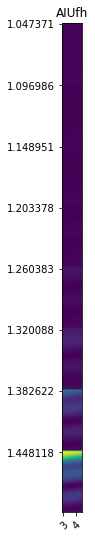

In [53]:
print(lambdas)
plot_heat_map(rmse_te, degrees, lambdas, "AIUfh")

# Generate predictions and save ouput in csv format for submission:

In [54]:
DATA_TEST_PATH = 'data/test.csv' # TODO: download train data and supply path here 
y_submission, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test.shape

(568238, 30)

In [55]:
submission_set=np.delete(tX_test,obj=columns_to_delete,axis=1)
tX = best_poly_exp.expand(submission_set)

In [56]:
print(tX.shape )

(568238, 116)


In [57]:
y_pred = predict_labels(best_weights, tX)
np.sum(y_pred)/len(y_pred)

-0.5294647665238861

In [36]:
OUTPUT_PATH = 'data/submission.csv' # TODO: fill in desired name of output file for submission

create_csv_submission(ids_test, y_pred, OUTPUT_PATH)